# Calc meteorite particle displacements

Equation for terminal sinking velocity based on:
Grace, J.R., 1986. Contacting modes and behaviour classification of gas—solid and other two‐phase suspensions. The Canadian Journal of Chemical Engineering, 64(3), pp.353-363.

In [1]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import gsw
from scipy.interpolate import interp1d
import numpy as np

## Set analysis parameters

In [2]:
# lat, lon of impact 1.3S, 147.6E
lat_I = -1.3
lon_I = 147.6
# nominal grid spacing
dl = 0.084
# ocean bottom depth [m]
z_bottom = -1700
# particle radius [m]
a = [1e-4, 1e-3, 1e-2, 1e-1]

## Read in GLORYs and HYCOM data

In [3]:
# base directory
base = '/net2/mjh/ipynb/MeteoriteAnalysis/'
# GLORYs files
flist_G = glob(f'{base}glorys*_section.nc')
# HYCOM files
flist_H = glob(f'{base}hycom*.nc')

In [4]:
# load profiles of t, s, u, and v
# GLORYs
DS_G = xr.open_mfdataset(flist_G,engine='netcdf4'
                        ).sel(latitude=slice(lat_I-dl,lat_I+dl),
                              longitude=slice(lon_I-dl,lon_I+dl)).assign_coords(radius=a)
DS_H = xr.open_mfdataset(flist_H,engine='netcdf4'
                        ).sel(lat=slice(lat_I-dl,lat_I+dl),
                              lon=slice(lon_I-dl,lon_I+dl)).assign_coords(radius=a)

# Functions for displacements

In [5]:
def w_sink(a,rho_f):
    import math
    # rho_f = fluid density [kg/m3]
    # a = particle radius [m]
    # Use the grace method which handles the transition between 
    # laminar and turbulent regimes for terminal velocity of 
    # sinking particle.
    
    # kinematic viscosity [kg/m s]
    mu = 1e-3
    # gravitational acceleration [m2/s]
    g = 9.8
    # particle density, iron at room temp [kg/m3]
    rho_p = 7.874e3
    
    # convert to diameter
    d = 2 * a
    
    # non-dimensionalize d
    d_str = d * (rho_f*g*(rho_p-rho_f)/(mu**2))**(1/3)
    # extra param
    w = math.log10(d_str)
    
    # calc of non-dimensionalized terminal velocity
    if d_str <=3.8:
        w_str = (d_str**2)/18 - 3.1234e-4*(d_str**5) + 1.6415e-6*(d_str**8) - 7.278e-10*(d_str**11)
    elif d_str > 3.8 and d_str <= 7.58:
        w_str = 10**(-1.5446 + 2.9162*w - 1.0432*w**2)
    elif d_str > 7.58 and d_str <= 227:
        w_str = 10**(-1.64758 + 2.94786*w - 1.09703*w**2 + 0.17129*w**3)
    else:
        w_str = 10**(5.1837 - 4.51034*w + 1.687*w**2 - 0.189135*w**3)
    
    # conversion back to physical units
    w_term = -w_str * ((mu*g*(rho_p-rho_f))/(rho_f**2))**(1/3)
    return w_term

In [6]:
def particle_displacement(a,T,S,u,v,z,depth_seafloor,lat):
    # Set initial values
    time = 0
    z_p = 0
    x_p = 0
    y_p = 0
    # Set integration time step [s]
    dt = 10
    while z_p > depth_seafloor:
        # get the pressure for the given depth
        p_z = gsw.p_from_z(z_p,lat)
        # get T and S at the starting depth
        if z_p > z[0] or z_p < z[-1]:
            S_z = interp1d(z,S,fill_value='extrapolate')(z_p)
            T_z = interp1d(z,T,fill_value='extrapolate')(z_p)
        else:
            S_z = interp1d(z,S,kind='cubic')(z_p)
            T_z = interp1d(z,T,kind='cubic')(z_p)
        # calc the density at the given depth
        rho_z = gsw.rho(S_z,T_z,p_z)
        # calc sinking velocity
        w = w_sink(a,rho_z)
        # calc dz for timestep
        dz = w * dt
        # get u, v over [z_p, z_p + dz]
        if z_p+(dz/2) > z[0] or z_p+(dz/2) < z[-1]:
            u_z = interp1d(z,u,fill_value='extrapolate')(z_p+(dz/2))
            v_z = interp1d(z,v,fill_value='extrapolate')(z_p+(dz/2))
        else:
            u_z = interp1d(z,u,kind='cubic')(z_p+(dz/2))
            v_z = interp1d(z,v,kind='cubic')(z_p+(dz/2))
        # update x_p, y_p
        x_p = x_p + (u_z * dt)
        y_p = y_p + (v_z * dt)
        # update z_p
        z_p = z_p + dz
        # update time
        time = time + dt
    return x_p, y_p, time

## Calc displacements for each particle size and model

### GLORYs

In [7]:
# Get len of each dimension
n_t = len(DS_G['time'])
n_lat = len(DS_G['latitude'])
n_lon = len(DS_G['longitude'])
n_a = len(a)

In [8]:
# Prelocate displacements for each particle size
DS_G['dx_p'] = (('time','latitude','longitude','radius'), np.zeros(DS_G.zos.shape + (n_a,)))
DS_G['dy_p'] = (('time','latitude','longitude','radius'), np.zeros(DS_G.zos.shape + (n_a,)))
DS_G['sink_time_p'] = (('time','latitude','longitude','radius'), np.zeros(DS_G.zos.shape + (n_a,)))

In [9]:
# run through each:
# time
for i_t in np.arange(n_t):
    # latitude
    for i_lat in np.arange(n_lat):
        # longitude
        for i_lon in np.arange(n_lon):
            # Extract profile
            ds = DS_G.isel(time=i_t,latitude=i_lat,longitude=i_lon).dropna('depth').squeeze()
            # get model values
            T = ds.thetao.values
            S = ds.so.values
            u = ds.uo.values
            v = ds.vo.values
            z = -ds.depth.values
            
            # particle radius
            for i_a in np.arange(n_a):
                # get particle radius
                r = ds.radius.values[i_a]
                
                # run calculation for particle displacement
                dx_p, dy_p, timeS = particle_displacement(r,T,S,u,v,z,z_bottom,lat_I)
                # append values
                DS_G['dx_p'][i_t,i_lat,i_lon,i_a] = dx_p
                DS_G['dy_p'][i_t,i_lat,i_lon,i_a] = dy_p
                DS_G['sink_time_p'][i_t,i_lat,i_lon,i_a] = timeS

### HYCOM

In [10]:
# Get len of each dimension
n_t = len(DS_H['time'])
n_lat = len(DS_H['lat'])
n_lon = len(DS_H['lon'])
n_a = len(a)

In [11]:
# Prelocate displacements for each particle size
DS_H['dx_p'] = (('time','lat','lon','radius'), np.zeros(DS_H.surf_el.shape + (n_a,)))
DS_H['dy_p'] = (('time','lat','lon','radius'), np.zeros(DS_H.surf_el.shape + (n_a,)))
DS_H['sink_time_p'] = (('time','lat','lon','radius'), np.zeros(DS_H.surf_el.shape + (n_a,)))

In [12]:
# run through each:
# time
for i_t in np.arange(n_t):
    # latitude
    for i_lat in np.arange(n_lat):
        # longitude
        for i_lon in np.arange(n_lon):
            # Extract profile
            ds = DS_H.isel(time=i_t,lat=i_lat,lon=i_lon).dropna('depth').squeeze()
            # get model values
            T = ds.water_temp.values
            S = ds.salinity.values
            u = ds.water_u.values
            v = ds.water_v.values
            z = -ds.depth.values
            
            # particle radius
            for i_a in np.arange(n_a):
                # get particle radius
                r = ds.radius.values[i_a]
                
                # run calculation for particle displacement
                dx_p, dy_p, timeS = particle_displacement(r,T,S,u,v,z,z_bottom,lat_I)
                # append values
                DS_H['dx_p'][i_t,i_lat,i_lon,i_a] = dx_p
                DS_H['dy_p'][i_t,i_lat,i_lon,i_a] = dy_p
                DS_H['sink_time_p'][i_t,i_lat,i_lon,i_a] = timeS

## Calculate the mean and error of the particle displacement for each model

In [13]:
cns = ['midnightblue', 'slateblue', 'dodgerblue','lightblue']

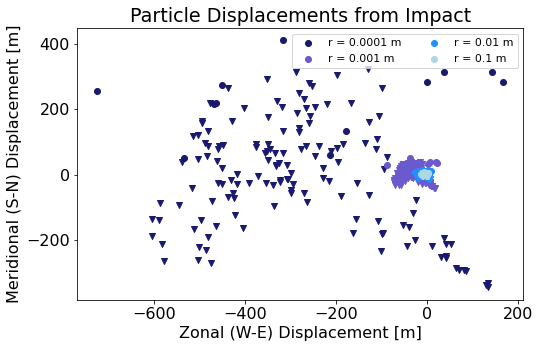

In [14]:
fig = plt.figure(figsize=(8,5))
for i in np.arange(len(a)):
    plt.scatter(DS_G['dx_p'].isel(radius=i),DS_G['dy_p'].isel(radius=i),c=cns[i],label=f'r = {a[i]} m')
#     plt.scatter(DS_G['dx_p'].isel(radius=i).mean(),DS_G['dy_p'].isel(radius=i).mean(),c=cns[i],s=200)
    plt.scatter(DS_H['dx_p'].isel(radius=i),DS_H['dy_p'].isel(radius=i),c=cns[i],marker='v')
#     plt.scatter(DS_H['dx_p'].isel(radius=i).mean(),DS_H['dy_p'].isel(radius=i).mean(),c=cns[i],s=200,marker='v')
plt.legend(ncol=2,prop={'size': 11})
plt.title('Particle Displacements from Impact')
plt.xlabel('Zonal (W-E) Displacement [m]')
plt.ylabel('Meridional (S-N) Displacement [m]')
plt.show()

In [15]:
N_G = len(DS_G['time'])*len(DS_G['latitude'])*len(DS_G['longitude'])
N_H = len(DS_H['time'])*len(DS_H['lat'])*len(DS_H['lon'])

In [16]:
for i in a:
    # Calculate the means
    dx_bar = ((1/(2*N_G))*DS_G['dx_p'].sel(radius=i).sum() + 
              (1/(2*N_H))*DS_H['dx_p'].sel(radius=i).sum()).values
    dy_bar = ((1/(2*N_G))*DS_G['dy_p'].sel(radius=i).sum() + 
              (1/(2*N_H))*DS_H['dy_p'].sel(radius=i).sum()).values
    # calc displacements
    dx = np.concatenate((DS_G['dx_p'].sel(radius=i).values.flatten(),
                         DS_H['dx_p'].sel(radius=i).values.flatten()))
    dy = np.concatenate((DS_G['dy_p'].sel(radius=i).values.flatten(),
                         DS_H['dy_p'].sel(radius=i).values.flatten()))
    dr = ((dx-dx_bar)**2 + (dy-dy_bar)**2)**(1/2)
    # calc rms displacement of all points
    error = ((dr**2).mean())**(1/2)
    # Print stats
    print(f'radius = {i}, mean dx,dy = {dx_bar},{dy_bar}, error = {error}')

radius = 0.0001, mean dx,dy = -267.4262670854735,114.69245952070317, error = 276.0698322260954
radius = 0.001, mean dx,dy = -31.047224385410317,13.79067294656189, error = 33.52529044763651
radius = 0.01, mean dx,dy = -8.81514730295393,4.11317969852663, error = 10.346335172859048
radius = 0.1, mean dx,dy = -4.3021183540172245,1.8414423488674512, error = 4.680033604185615
